# センチメント分析を活用したリアルタイム金融ニュースの定量評価
## ― 金融市場における「感情データ」を意思決定に活かす ―
作成者：志村 美代子<br>作成日：2025年2月27日

---

<br>企業の評判や市場心理は、ニュースや報道といった非構造化な情報によって大きく左右されています。特に金融市場では、リアルタイムで流れるニュースが投資家心理や市場のトレンド形成に直接的な影響を及ぼすため、情報を定量的かつ客観的なデータとして把握する重要性が高まっています。

本調査報告では、次の問いに焦点を当てて分析を実施しました。

> **「リアルタイムで流通する金融ニュースは、市場や投資家の意思決定にどのような感情的影響を与えているのか？」**

そのために、自然言語処理技術を活用したセンチメント分析を通じて、金融ニュースのタイトルから感情スコアを算出・分類し、その影響度を定量的に評価し可視化する分析プロトタイプを構築しました。

本報告書は、センチメント分析を使用して、定性的な情報を定量化することで市場におけるリスク評価や投資戦略の最適化に寄与することを目的としています。

## 分析フレームワーク

- **Alpha Vantage API** を活用し、リアルタイム金融ニュースを収集
- **VADER Sentiment Analyzer** によるニュースタイトルのセンチメントスコア算出
- スコアに基づく感情分類（Positive / Neutral / Negative）と、センチメント分布の可視化
- 分析結果をCSV形式でエクスポートして他システムとの連携を可能にする

---


# 1. 必要なライブラリのインストール

In [ ]:
!pip install requests vaderSentiment

Google Colab に初期インストールされていないライブラリを導入します。

*   requests：API通信を行うための標準的なライブラリ。Web上のデータにアクセスするために使います。
*   VaderSentiment：VADER（Valence Aware Dictionary and sEntiment Reasoner）は、英語テキスト向けに特化している感情分析ツールで、文脈理解に強く、SNSやニュース見出しのような短文にも対応しているものです。


# 2. ライブラリのインポート

In [ ]:
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

Pythonでのデータ処理や可視化に必要なライブラリ群を読み込みます。

*   pandas は表形式（DataFrame）でのデータ操作を可能にします。
*   matplotlib.pyplot はデータの可視化（グラフ・ヒストグラム）に使います。
*   numpy は数値計算やグラフの bin（区切り）の定義に使用します。

# 3. APIを通じたニュースデータの取得

In [ ]:
API_KEY = "MY KEY"  # Alpha VantageのAPI KEYを入力
url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&apikey={API_KEY}"
response = requests.get(url)
data = response.json()

Alpha Vantage の API を使用して、リアルタイムのニュースデータをJSON形式で取得します。url でエンドポイントとパラメータを組み立て、requests.get()でWebにアクセスしています。

# 4. ニュースデータの整形と DataFrame 化

In [ ]:
news_list = []
for article in data.get("feed", []):
    news_list.append({
        "title": article["title"],
        "summary": article["summary"],
        "source": article["source"],
        "time_published": article["time_published"]
    })
news_df = pd.DataFrame(news_list)

APIから得られた辞書形式のデータをリストに整形し直して、Pandas の DataFrame に変換します。これによりのちの分析・可視化が格段にしやすくなります。ニュースの「タイトル」「要約」「媒体」「公開日時」の4項目を取得します。

# 5. VADER による感情分析の実行

In [ ]:
news_df["title"] = news_df["title"].fillna("").astype(str)
analyzer = SentimentIntensityAnalyzer()
news_df["sentiment_score"] = news_df["title"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

ここで、**ニュースタイトルに対するセンチメントスコア（感情の強度）**を算出します。

VADER の polarity_scores() は、文章に対して 4 つのスコアを返します（pos, neu, neg, compound）。

*   compound は総合スコアで、-1（極端にネガティブ）〜 +1（極端にポジティブ）までの値
*   fillna() は欠損値対策、astype(str) は型変換に用います






# 6. 感情カテゴリへの分類

In [ ]:
def categorize_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

news_df["sentiment_category"] = news_df["sentiment_score"].apply(categorize_sentiment)

スコアに基づいて、以下のようにカテゴリ分けを行いました。

*   Positive：+0.2 より大きい（ポジティブなニュース）
*   Negative：-0.2 より小さい（ネガティブなニュース）
* Neutral：-0.2〜+0.2の範囲内（中立）

このしきい値（±0.2）は経験的に妥当とされる値を用いています。

# 7. 平均センチメントスコアの算出と確認

全体のセンチメントの平均を計算することで、**現在のニュース全体のムード（楽観／悲観）**を数値として捉えることができます。

In [ ]:
print(news_df[["title", "sentiment_score", "sentiment_category"]])
average_sentiment = news_df["sentiment_score"].mean()
print(f"ニュースの平均センチメントスコア: {average_sentiment:.2f}")

                                                title  sentiment_score  \
0   Vanuatu passes long-awaited crypto laws that w...           0.0000   
1   Bitcoin Entrepreneur Sets Off On Historic Pola...           0.8481   
2   Aura Reports Updated Mineral Reserves And Mine...           0.7783   
3   Aura Reports Updated Mineral Reserves And Mine...           0.7783   
4   Comcast Technology Solutions Launches Comcast ...           0.1779   
5   Barclays' private credit partner struggles to ...           0.0258   
6   First cat bond ETF opens new frontier in low-c...           0.0000   
7   Australia central bank says it's cautious abou...          -0.1027   
8   Barco Announces Upcoming 2025 Sony Pictures Ti...           0.0000   
9   PEPE Outgains Dogecoin, Shiba Inu With 4% Rall...           0.0000   
10  There's More to North Korea's Hacking Ops Than...           0.0000   
11  Tom Lee Says Markets Are 'Deeply Oversold,' Ex...          -0.4939   
12  Banking liquidity expected to shif

In [ ]:
from IPython.display import display, HTML

# ポジティブなニュース 10 件
print("\nポジティブなニュース TOP 10：\n")
top_positive = news_df.sort_values(by="sentiment_score", ascending=False).head(10)
display(HTML(top_positive[["title", "sentiment_score"]].to_html(index=False)))

# ネガティブなニュース 10 件
print("\nネガティブなニュース TOP 10：\n")
top_negative = news_df.sort_values(by="sentiment_score", ascending=True).head(10)
display(HTML(top_negative[["title", "sentiment_score"]].to_html(index=False)))


ポジティブなニュース TOP 10：



title,sentiment_score
"Bitcoin, Ethereum, Dogecoin Rise As Trump Family Foray Into BTC Mining: Whale Wallet Spike 'Slight Sign Of Confidence,' Says Analyst - Grayscale Bitcoin Mini Trust ( BTC ) Common units of fractional undivided beneficial interest ( ARCA:BTC )",0.9049
Bitcoin Entrepreneur Sets Off On Historic Polar Orbit Spaceflight Powered By Elon Musk's SpaceX - Grayscale Bitcoin Mini Trust ( BTC ) Common units of fractional undivided beneficial interest ( ARCA:BTC ),0.8481
"Aura Reports Updated Mineral Reserves And Mineral Resources For The Year-Ended 2024, Highlighting Ongoing Exploration And Strong Growth Trajectory",0.7783
"Aura Reports Updated Mineral Reserves And Mineral Resources For The Year-Ended 2024, Highlighting Ongoing Exploration And Strong Growth Trajectory - Aura Minerals ( OTC:ORAAF )",0.7783
TSMC affirms commitment to Taiwan with new domestic fab,0.6808
"Jack Ma Drew A Parallel Between Himself And Forrest Gump At The Alibaba IPO Over A Decade Ago - The Philosophy Inspired By The Iconic Character Has Helped Build A Tech Giant Worth $319 Billion - Alibaba Gr Hldgs ( NYSE:BABA ) , NVIDIA ( NASDAQ:NVDA )",0.6249
"Sam Altman-Led OpenAI Releases Open-Weight AI Model With Reasoning Capabilities As DeepSeek And Meta Taste Success - Meta Platforms ( NASDAQ:META ) , SoftBank Group ( OTC:SFTBF )",0.5719
"Cathie Wood Defies CoreWeave IPO Slump, Ark Snaps Up $3.6 Million Worth Of Stock In Nvidia-Backed Company - Apple ( NASDAQ:AAPL ) , ARK Innovation ETF ( BATS:ARKK )",0.5423
Firm Capital Property Trust Reports Q4/2024 Results,0.5106
"Coinbase CEO Slams 'Outdated' Stablecoin Rules, Pushes for Interest Payments",0.4588



ネガティブなニュース TOP 10：



title,sentiment_score
zkLend hacker claims losing stolen ETH to Tornado Cash phishing site,-0.7003
"S&P 500 Just Had Its Worst Quarter vs. Global Stocks Since 1988: What's Driving The Rout - Deckers Outdoor ( NYSE:DECK ) , Marvell Tech ( NASDAQ:MRVL )",-0.6249
"Tom Lee Says Markets Are 'Deeply Oversold,' Expects Bitcoin To Lead Rebound As Investors Fear Trump's Tariff Impact - SPDR S&P 500 ( ARCA:SPY )",-0.4939
Australia central bank says it's cautious about inflation outlook as it keeps rates steady at 4.1%,-0.1027
"Jim Cramer Asks Trump To Take Stock As Markets Swing Again Ahead Of 'Liberation Day' - Discover Financial servs ( NYSE:DFS ) , GRAIL ( NASDAQ:GRAL )",0.0000
Silynxcom Ltd. Announces Pricing of Public Offering,0.0000
"Barco Announces Upcoming 2025 Sony Pictures Titles for Release in HDR: KARATE KID: LEGENDS, 28 YEARS LATER",0.0000
There's More to North Korea's Hacking Ops Than Just Lazarus Group: Paradigm,0.0000
"Nvidia, Moderna, Lucid, Dominari Holdings, Tesla: Why These 5 Stocks Are On Investors' Radars Today - Dominari Holdings ( NASDAQ:DOMH )",0.0000
Trump has dubbed April 2 'Liberation Day' for tariffs. Here's what to expect - ETCFO,0.0000


# 8. センチメント分布の可視化（ヒストグラム）

ヒストグラムはセンチメントスコアの分布を視覚的に把握するためのものです。

ポジティブ、ニュートラル、ネガティブの各カテゴリを色分け表示します。分布の偏りを見ることで、**報道の全体的な傾向（ポジティブ寄りか、ネガティブ寄りか）**が一目で分かります。

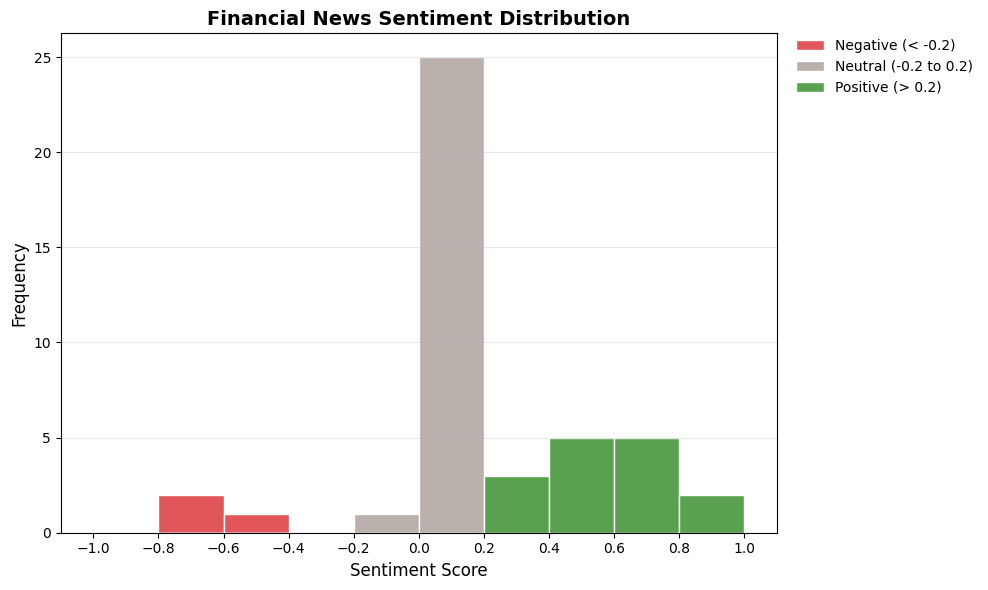

In [ ]:
# 各カテゴリごとにスコアを抽出
positive = news_df[news_df["sentiment_score"] > 0.2]["sentiment_score"]
neutral = news_df[(news_df["sentiment_score"] >= -0.2) & (news_df["sentiment_score"] <= 0.2)]["sentiment_score"]
negative = news_df[news_df["sentiment_score"] < -0.2]["sentiment_score"]

# bin（区切り）を定義
bins = np.arange(-1.0, 1.1, 0.2)

color_positive = "#59A14F"
color_neutral = "#BAB0AC"
color_negative = "#E15759"

# ヒストグラムの描画
plt.figure(figsize=(10, 6))
plt.hist(negative, bins=bins, color=color_negative, alpha=1, edgecolor="white", label="Negative (< -0.2)")
plt.hist(neutral, bins=bins, color=color_neutral, alpha=1, edgecolor="white", label="Neutral (-0.2 to 0.2)")
plt.hist(positive, bins=bins, color=color_positive, alpha=1, edgecolor="white", label="Positive (> 0.2)")

# グラフタイトル・軸ラベルの調整
plt.title("Financial News Sentiment Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)


plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)
plt.grid(axis='y', alpha=0.3)
plt.xticks(np.arange(-1.0, 1.1, 0.2))
plt.tight_layout()
plt.show()

# 9. 分析結果の保存

In [ ]:
news_df.to_csv("news_sentiment.csv", index=False)

最後に分析したデータを CSV ファイルとして保存します。

*   BIツール（Power BI、Tableau）への取り込み
*   定期的なログとしての蓄積
*   統計ツールや報告資料への活用

などに活用できます。



## 実務への応用可能性

この手法はさまざまなビジネス課題への展開が可能です。

- **風評リスクの可視化・予兆検知**  
- **ESG / サステナビリティ観点での非財務リスク評価**  
- **業界・競合分析における定性的情報の構造化**  
- **経営・戦略判断に資するインフォメーション・インテリジェンスの強化**

# 活用した成果

このツールを活用し、センチメントスコアの高いインパクトの強いニュースを抽出・分析し、LinkedInなどのソーシャルメディア上で解説することを実施しました。

これにより、フォロワーとの質の高い情報共有が可能となり、2025年4月現在、LinkedInのフォロワー数は6,000人を超えました。データに基づき、情報発信を通じて、視点を広く届けることを継続したいと思います。